# Imports

In [1]:
import joblib

import constants.paths as pth
from src.preprocessing import preprocess_data  # noqa: F401
from src.utils.cumulative_probability import plot_cumulative_probability
from src.utils.load_data import load_data


In [2]:
data_to_predict = load_data(pth.NEW_LOANS_PATH)
scaled_data_to_predict, _ = preprocess_data(data_to_predict)

In [3]:
data_to_predict

,id,sex,employment,married,income,signal2
0,1,M,employed,0,29758,0.000000
1,2,F,retired,1,6140,0.000000
2,3,F,employed,1,27186,0.008139
3,4,M,employed,1,8429,0.624570
4,5,M,retired,1,2820,0.097230
...,...,...,...,...,...,...
99995,99996,M,retired,1,9027,0.070968
99996,99997,M,student,0,6229,0.635176
99997,99998,M,employed,1,6471,0.748987
99998,99999,M,unemployed,0,32654,0.000000


In [4]:
scaled_data_to_predict

,sex_M,employment_retired,employment_student,employment_unemployed,married_1,income,signal2
0,1.0,0.0,0.0,0.0,0.0,10.300887,0.000000
1,0.0,1.0,0.0,0.0,1.0,8.722743,0.000000
2,0.0,0.0,0.0,0.0,1.0,10.210494,0.008139
3,1.0,0.0,0.0,0.0,1.0,9.039552,0.624570
4,1.0,1.0,0.0,0.0,1.0,7.944847,0.097230
...,...,...,...,...,...,...,...
99995,1.0,1.0,0.0,0.0,1.0,9.108086,0.070968
99996,1.0,0.0,1.0,0.0,0.0,8.737132,0.635176
99997,1.0,0.0,0.0,0.0,1.0,8.775240,0.748987
99998,1.0,0.0,0.0,1.0,0.0,10.393753,0.000000


In [5]:
# Make predictions
model_name = "random_forest"  # Change as needed
model = joblib.load(pth.MODELS_DIR / f"{model_name}.pkl")  # Load your trained model

proba_predictions = model.predict_proba(scaled_data_to_predict)[
    :, 1
]  # Probability of the positive class (default probability)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    2.5s finished


In [7]:
data_to_predict["predicted_default_proba"] = proba_predictions

The function
$$
f : x \mapsto \frac{x}{1-x}
$$
is strictly growing on $[0,1[$ and $f(\frac{1}{2})=1$.

Thus, any predicted default probability above $0.5$ gives a break even interest rate above $100\%$. We cannot fix interest rates above $100\%$.

0.1    0.000000
0.9    0.336202
Name: predicted_default_proba, dtype: float64


<Axes: >

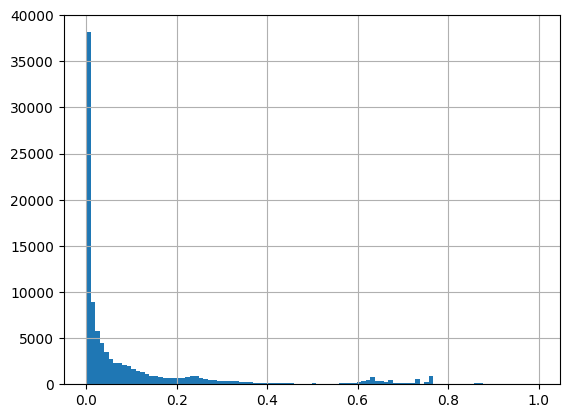

In [5]:
print(data_to_predict["predicted_default_proba"].quantile([0.1, 0.90]))
data_to_predict["predicted_default_proba"].hist(bins=100)

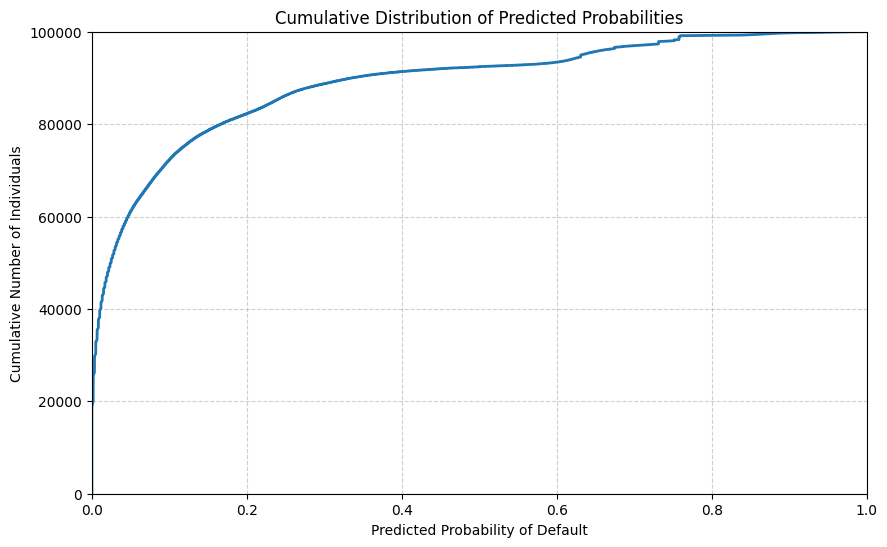

In [6]:
plot_cumulative_probability(data_to_predict["predicted_default_proba"])

In [8]:
import pandas as pd

In [9]:
data_to_predict["predicted_default_proba"] = data_to_predict[
    "predicted_default_proba"
].round(2)

# Set probabilities above 0.17 to NaN (we won't offer loans to these customers)
mask_over_threshold = data_to_predict["predicted_default_proba"] > 0.17
data_to_predict["predicted_default_proba"] = data_to_predict[
    "predicted_default_proba"
].where(~mask_over_threshold, pd.NA)

# We compute the breake-even interest rate for each loan
data_to_predict["breakeven_interest_rate"] = data_to_predict[
    "predicted_default_proba"
] / (1 - data_to_predict["predicted_default_proba"])


In [10]:
data_to_predict["rate"] = (
    data_to_predict["breakeven_interest_rate"] * 1.2
)  # Add a 20% margin

mask_no_interest_rate = data_to_predict["predicted_default_proba"] == 0
data_to_predict["rate"] = data_to_predict["rate"].where(
    ~mask_no_interest_rate, 0.01
)  # Minimum interest rate of 1%
data_to_predict["rate"] = data_to_predict["rate"].round(2)

In [11]:
data_to_predict

,id,sex,employment,married,income,signal2,predicted_default_proba,breakeven_interest_rate,rate
0,1,M,employed,0,29758,0.000000,0.00,0.000000,0.01
1,2,F,retired,1,6140,0.000000,0.02,0.020408,0.02
2,3,F,employed,1,27186,0.008139,0.03,0.030928,0.04
3,4,M,employed,1,8429,0.624570,0.04,0.041667,0.05
4,5,M,retired,1,2820,0.097230,0.04,0.041667,0.05
...,...,...,...,...,...,...,...,...,...
99995,99996,M,retired,1,9027,0.070968,0.15,0.176471,0.21
99996,99997,M,student,0,6229,0.635176,0.14,0.162791,0.20
99997,99998,M,employed,1,6471,0.748987,0.16,0.190476,0.23
99998,99999,M,unemployed,0,32654,0.000000,0.00,0.000000,0.01


In [ ]:
final_predictions = data_to_predict[["id", "rate"]]
final_predictions.index = final_predictions["id"]
final_predictions = final_predictions.drop(columns=["id"])

In [ ]:
final_predictions

,id,rate
id,,
1,1,0.01
2,2,0.02
3,3,0.04
4,4,0.05
5,5,0.05
...,...,...
99996,99996,0.21
99997,99997,0.20
99998,99998,0.23
